In [7]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
sym.init_printing(use_latex="mathjax")
from scipy.optimize import root
# scipy.optimize.root

Rb, Rd and I all blowing up/down at zmax or at 500 for all initial conditions

In [157]:
v=0.25
lbg=0.1
k=0.0003
kbg=0.4
I0=300
mumax=1.2
romax=0.2
m=15
qmax=0.04
qmin=0.004
h=120
d=10


N=10000
zmax = 30
z = np.linspace(0,zmax,N)    # (start,stop, number of nodes)

Rd1_guess = 30               # as specified
A1_guess = 100
Rb1_guess = A1_guess/350

A1,Rb1,Rd1 = sym.symbols('A1 Rb1 Rd1')

1/qmin

250.0

    * A1_guess = 250*Rb1_guess:   A is increasing
    * A1_guess = 500*Rb1_guess:   A is decreasing
    * A1_guess = 499*Rb1_guess:   A is increasing
    * A1_guess = 499.9*Rb1_guess: A is up and down
    * A1_guess = 499.5*Rb1_guess: RuntimeWarning: overflow encountered
    
Initially homogeneous vertical distributions of algal biomass and dissolved nutrients of 100 mg C m3 and 30 mg P m3, respectively.

    * Rb1_guess = A1_guess/500 or /250 or /700:   A goes negative
    
    * Rb1_guess = A1_guess/300 => A1 and A2 increase but A1 still goes negative
      Rd1_guess = 30               # as specified
      A1_guess = 100
      
    * Rb1_guess = A1_guess/350 => satisfactory solutions for N > 10,000, z = 30 only 
      Rd1_guess = 30               # as specified
      A1_guess = 100

In [158]:
## functions
def q(Rb, A): # don't need this
    return Rb/A
    
# Specific algal growth rate p is an increasing, saturating function of light intensity I and algal nutrient quota q
def p(I,q, mumax=mumax, qmin=qmin, h=h):
    return mumax * (1 - qmin/q) * (I/(h + I))

def ro(q, Rd, romax = romax, qmax = qmax, qmin=qmin, m=m):
    return romax * (qmax-q)/(qmax-qmin) * ( Rd/(m + Rd) )

In [159]:
def plankton_equations(y):
    A1 = y[0]
    A2 = y[1]
    Rb1 = y[2]
    Rb2 = y[3]
    Rd1 = y[4]
    Rd2 = y[5]
    I = y[6]
    q = Rb1/A1
    
    derivatives = np.array((A2,
                     (v*A2 - p(I,q)*A1 + lbg*A1)/d,
                     Rb2,
                     (v*Rb2 - ro(q,Rd1)*A1 - lbg*Rb1)/d,
                     Rd2,
                     (ro(q,Rd1)*A1 - lbg*Rb1)/d,
                     -(k*A1 + kbg)*I))
    return derivatives

initial_guess = np.array([])
initial_conditions = np.array([A1_guess,
                              v*A1_guess/d,
                              Rb1_guess,
                              v*Rb1_guess/d,
                              Rd1_guess,
                              0,
                              I0])

def end_values(values_at_zmax_integrated):
    """ Creates Robin boundary conditions using values at zmax of integrated function and adds known BCs."""
    
    Rb1_end = values_at_zmax_integrated[1]
    Rd2_end = values_at_zmax_integrated[3]
    values_at_zmax = np.array([0,           # A2
                          d*Rd2_end/v,  # Rb1
                          0,            # Rb2
                          v*Rb1_end/v]) # Rd2
    return values_at_zmax

In [160]:
def one_step_rk4(f, xvinit, Tmax, N):
    xv = xvinit                            # set first ROW to the initial conditions
    h = Tmax / N                           # step size
    k1 = f(xv)
    k2 = f(xv + h/2.0*k1)
    k3 = f(xv + h/2.0*k2)
    k4 = f(xv + h*k3)
    next_step = xv[0] + h/6.0 *( k1 + 2*k2 + 2*k3 + k4)
    return next_step

In [161]:
def rk4(f, xvinit, Tmax, N):               # N=number of steps
    T = np.linspace(0, Tmax, N+1)
    xv = np.zeros( (len(T), len(xvinit)) ) # matrix with # cols=# initial conditions
    xv[0] = xvinit                         # set first ROW = initial conditions
    h = Tmax / N                           # step size
    for i in range(N):
        k1 = f(xv[i])
        k2 = f(xv[i] + h/2.0*k1)
        k3 = f(xv[i] + h/2.0*k2)
        k4 = f(xv[i] + h*k3)
        xv[i+1] = xv[i] + h/6.0 *( k1 + 2*k2 + 2*k3 + k4)
    return T, xv

In [162]:
# Can see things blowing up immediately
first_step = one_step_rk4(lambda x: plankton_equations(x), initial_conditions, zmax, N)
second_step = one_step_rk4(lambda x: plankton_equations(x), first_step, zmax, N)
second_step

array([100.30755197, 100.00174212, 100.30772348, 100.15138682,
       100.30731913,  99.86514968,  99.87908786])

In [163]:
initial_conditions

array([1.00000000e+02, 2.50000000e+00, 2.85714286e-01, 7.14285714e-03,
       3.00000000e+01, 0.00000000e+00, 3.00000000e+02])

In [164]:
first_step

array([100.00752021, 100.01347259, 100.00001523,  99.99586467,
       100.00000618, 100.00411857,  99.61324849])

In [165]:
second_step

array([100.30755197, 100.00174212, 100.30772348, 100.15138682,
       100.30731913,  99.86514968,  99.87908786])

In [166]:
z, derivs = rk4(lambda x: plankton_equations(x), initial_conditions, zmax, N)

Text(0.5, 0, 'z')

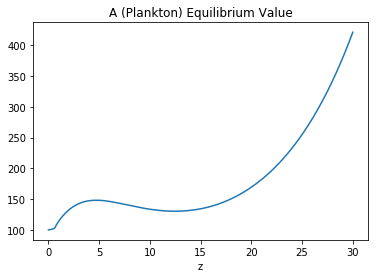

In [167]:
plt.plot(z,derivs[:,0])
plt.title('A (Plankton) Equilibrium Value')
plt.xlabel('z')

Text(0.5, 0, 'z')

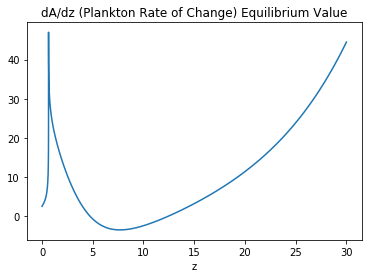

In [168]:
plt.plot(z,derivs[:,1])
plt.title('dA/dz (Plankton Rate of Change) Equilibrium Value')
plt.xlabel('z')

Text(0.5, 0, 'z')

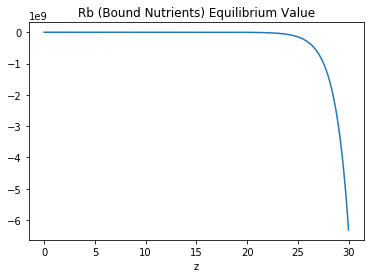

In [169]:
plt.plot(z,derivs[:,2])
plt.title('Rb (Bound Nutrients) Equilibrium Value')
plt.xlabel('z')

Text(0.5, 0, 'z')

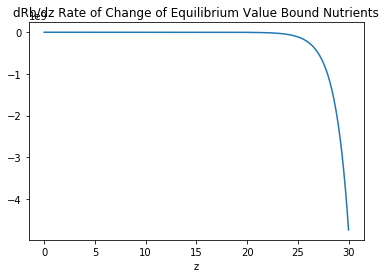

In [170]:
plt.plot(z,derivs[:,3])
plt.title('dRb/dz Rate of Change of Equilibrium Value Bound Nutrients')
plt.xlabel('z')

Text(0.5, 0, 'z')

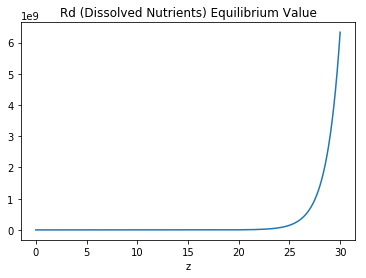

In [171]:
plt.plot(z,derivs[:,4])
plt.title('Rd (Dissolved Nutrients) Equilibrium Value')
plt.xlabel('z')

Text(0.5, 0, 'z')

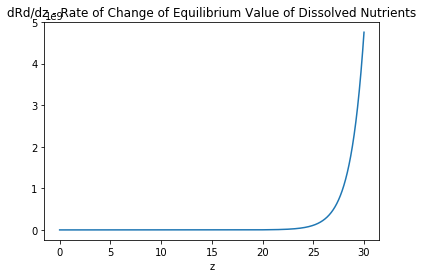

In [172]:
plt.plot(z,derivs[:,5])
plt.title('dRd/dz - Rate of Change of Equilibrium Value of Dissolved Nutrients')
plt.xlabel('z')

Text(0.5, 0, 'z')

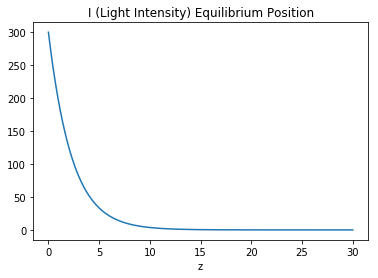

In [173]:
plt.plot(z,derivs[:,6])
plt.title('I (Light Intensity) Equilibrium Position')
plt.xlabel('z')

    values_at_zmax = np.array([0,           # A2
                          d*Rd2_end/v,  # Rb1
                          0,            # Rb2
                          v*Rb1_end/v]) # Rd2

In [174]:
len(derivs)
values_at_zmax_integrated = derivs[N,[2,3,4,6]]
values_at_zmax_integrated

array([-6.31612684e+09, -4.74482033e+09,  6.32977485e+09,  3.59494438e-04])

In [137]:
values_at_zmax = end_values(values_at_zmax_integrated)
values_at_zmax

array([ 0.00000000e+00,  1.43797775e-02,  0.00000000e+00, -4.74482033e+09])

In [133]:
def residuals(initial_conditions):
    z, derivs = rk4(lambda x: plankton_equations(x), initial_conditions, zmax, N)
    
    values_at_zmax_integrated = derivs[N,[2,3,4,6]]       # actual values obtained through integration
    BCs_at_zmax = end_values(values_at_zmax_integrated)   # expected relationship between values with Robin BCs
    residuals = BCs_at_zmax - values_at_zmax_integrated
    
    return residuals

[Note on method to use ](https://stackoverflow.com/questions/30636988/python-scipy-fsolve-mismatch-between-the-input-and-output-shape-of-the-func-a)

In [177]:
help(root)

Help on function root in module scipy.optimize._root:

root(fun, x0, args=(), method='hybr', jac=None, tol=None, callback=None, options=None)
    Find a root of a vector function.
    
    Parameters
    ----------
    fun : callable
        A vector function to find a root of.
    x0 : ndarray
        Initial guess.
    args : tuple, optional
        Extra arguments passed to the objective function and its Jacobian.
    method : str, optional
        Type of solver.  Should be one of
    
            - 'hybr'             :ref:`(see here) <optimize.root-hybr>`
            - 'lm'               :ref:`(see here) <optimize.root-lm>`
            - 'broyden1'         :ref:`(see here) <optimize.root-broyden1>`
            - 'broyden2'         :ref:`(see here) <optimize.root-broyden2>`
            - 'anderson'         :ref:`(see here) <optimize.root-anderson>`
            - 'linearmixing'     :ref:`(see here) <optimize.root-linearmixing>`
            - 'diagbroyden'      :ref:`(see here) <opti

In [134]:
residuals(initial_conditions)

(array([ 6.31612684e+09,  4.74482033e+09, -6.32977485e+09, -4.74482033e+09]),
 array([ 0.00000000e+00,  1.43797775e-02,  0.00000000e+00, -4.74482033e+09]),
 array([-6.31612684e+09, -4.74482033e+09,  6.32977485e+09,  3.59494438e-04]))

In [182]:
root(residuals, initial_conditions, method='anderson')

ValueError: operands could not be broadcast together with shapes (7,) (12,) 

In [175]:
help(fsolve)

NameError: name 'fsolve' is not defined